In [65]:
# Import necessary modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon, MultiPoint

In [8]:
# There are basically two ways of conducting PIP in Shapely:

# using a function called .within() that checks if a point is within a polygon
# using a function called .contains() that checks if a polygon contains a point

#these functions are not exclusive to Points can work on check with LineString and polygons

In [25]:
#first let's create our points
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

print("p1:", p1,"\np2:",p2)

p1: POINT (24.952242 60.1696017) 
p2: POINT (24.976567 60.16125)


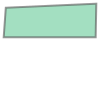

In [20]:
#create a polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)
poly

In [29]:
#let's check if the points are within polygon
p1.within(poly)
print(p1.within(poly))

p2.within(poly)
print(p2.within(poly))

True
False


In [34]:
#p1 is close to centroid of poly
# Our point
print(p1)

# The centroid
print(poly.centroid)


POINT (24.952242 60.1696017)
POINT (24.95224242849236 60.16960179038188)


In [38]:
#It is also possible to do PIP other way around, i.e. to check if polygon contains a point
poly.contains(p1)

True

In [37]:
poly.contains(p2)

False

Which one should you use then? Well, it depends:

if you have many points and just one polygon and you try to find out which one of them is inside the polygon:
    you need to iterate over the points and check one at a time if it is within() the polygon specified

if you have many polygons and just one point and you want to find out which polygon contains the point
    you need to iterate over the polygons until you find a polygon that contains() the point specified (assuming there are no overlapping polygons)

Intersect

Another typical geospatial operation is to see if a geometry intersect or touches another one. 

The difference between these two is that:

if objects intersect, the boundary and interior of an object needs to intersect in any way with those of the other.

If an object touches the other one, it is only necessary to have (at least) a single point of their boundaries in common but their interiors shoud NOT intersect.

In [39]:
#lets create 2 linestrings

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

In [41]:
#let's see if they intersect
line_a.intersects(line_b)

True

In [42]:
#let's see if they touch each other
line_a.touches(line_b)

True

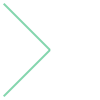

In [47]:
#can create a multiline to plot for the 2 lines look like with each other
multi_line = MultiLineString([line_a, line_b])
multi_line

In [48]:
#if overlap fully they do not touch due to spatial relationship rules
#let's check if the line touches itself
line_a.touches(line_a)

False

In [49]:
line_a.intersects(line_a)

True

Spatial Join

In [50]:
# Filepath
fp = "/Users/JCHONG/City-of-Toronto/Pop15/Vaestotietoruudukko_2015.shp"

# Read the data
pop = gpd.read_file(fp)

In [51]:
pop.head()

,INDEX,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,IKA70_79,IKA_YLI80,geometry
0,688,8,31.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.99532626 6689749.005069185,..."
1,703,6,42.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.99532626 6685998.998064222,..."
2,710,8,44.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.99532626 6684249.004130407,..."
3,711,7,64.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.99532626 6683999.004997005,..."
4,715,19,23.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.99532626 6682998.998461431,..."


In [52]:
#change the name of a column
#Let’s change the name of that columns into pop15 so that it is more intuitive. Changing column names is easy in 
#Pandas / Geopandas using a function called rename() where we pass a dictionary to a parameter 
#columns={'oldname': 'newname'}.
pop = pop.rename(columns ={'ASUKKAITA':'pop15'})

In [57]:
#dropping all unnessecaary columns
# Columns that will be sected
selected_cols = ['pop15', 'geometry']

# Select those columns
pop = pop[selected_cols]

# Let's see the last 2 rows
pop.tail(2)


,pop15,geometry
5782,9,"POLYGON ((25513499.99632164 6685498.999797418,..."
5783,30244,"POLYGON ((25513999.999929 6659998.998172711, 2..."


In [59]:
# Addresses filpath
addr_fp = r"/Users/JChong/City-of-Toronto/Data/addresses_epsg3879.shp"

# Read data
addresses = gpd.read_file(addr_fp)

# Check the head of the file
addresses.head(2)


,address,id,geometry
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (25496123.30852197 6672833.941567578)
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (25496774.28242895 6672999.698581985)


In [60]:
#checking if their coordinate system is the same
addresses.crs == pop.crs

True

In [61]:
# Make a spatial join
# op means operation so we want addresses that are within population polygons, other op include intersect and contain
#how inner is use intersection of keys from both dfs; retain only left_df geometry column
join = gpd.sjoin(addresses, pop, how="inner", op="within")

join.head()

,address,id,geometry,index_right,pop15
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (25496123.30852197 6672833.941567578),3326,173
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (25496774.28242895 6672999.698581985),3449,31
10,"Rautatientori 1, 00100 Helsinki, Finland",1011,POINT (25496808.64582102 6673146.836896984),3449,31
3,"Itäväylä, 00900 Helsinki, Finland",1004,POINT (25505098.34340289 6677972.568484426),5112,353
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (25495639.56049686 6671520.343245601),3259,1397


In [62]:
# Output path
outfp = r"/Users/JChong/City-of-Toronto/Data/addresses_pop15_epsg3979.shp"

# Save to disk
join.to_file(outfp)

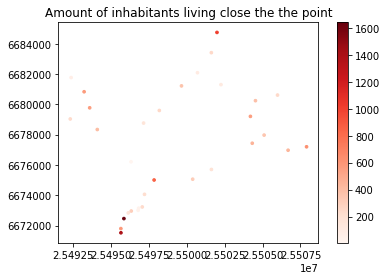

In [67]:
#Plot the points and use the pop15 column to indicate the color. cmap -parameter tells to use a sequential colormap 
#for the values, markersize adjusts the size of a point, scheme parameter can be used to adjust the classification 
#method based on pysal, and legend tells that we want to have a legend.

import matplotlib.pyplot as plt

# Plot the points with population info
join.plot(column='pop15', cmap="Reds", markersize=7, legend=True);

# Add title
plt.title("Amount of inhabitants living close the the point");

# Remove white space around the figure
plt.tight_layout()